### Read in raw ACCESS-S2 output and check that climatology is different from calibrated 

In [64]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/home/563/rl5183/Documents/CSIRO')
import categorical_enso_functions as func
import xesmf
import cf_xarray

In [8]:
# Dask client
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1)#(memory_limit=None, n_cpus=15≈1)
client.cluster.scale(8) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40627,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37251,Total threads: 1
Dashboard: /proxy/34175/status,Memory: 0 B
Nanny: tcp://127.0.0.1:46385,


2025-03-21 12:12:03,716 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 553d3bee3fda81716e70e2539fa6f0bb initialized by task ('rechunk-merge-rechunk-transfer-706109f17ba67b5ee940d95d584fa384', 0, 0, 0, 0, 0, 0, 0, 3) executed on worker tcp://127.0.0.1:36357
2025-03-21 12:12:16,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 553d3bee3fda81716e70e2539fa6f0bb deactivated due to stimulus 'task-finished-1742519536.1593776'
2025-03-21 12:24:20,026 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4c66d213eac1c934f850828c3bb38009 initialized by task ('rechunk-merge-rechunk-transfer-423acd9b1de6c8428d4ada1d19fd5055', 0, 0, 0, 0, 0, 0, 0, 3) executed on worker tcp://127.0.0.1:38385
2025-03-21 12:24:43,972 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4c66d213eac1c934f850828c3bb38009 deactivated due to stimulus 'task-finished-1742520283.970699'
2025-03-21 12:26:32,842 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 89a5add0cb7b5e7ac

In [9]:
# Silence warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [10]:
# Function for plotting gridlines
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

#### AGCD

In [12]:
# AGCD landmask
landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

In [13]:
# AGCD data (v2 for precip) 
file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# Generate list of file paths for years 1960-2022
years = range(1960, 2023)  
paths = [file_pattern.format(year) for year in years]
# Open dataset 
precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip

In [18]:
son_yearly = precip.sel(time=precip.time.dt.season == "SON").groupby("time.year").mean("time").where(landmask.data==1)

#### ACCESS-S2 Lag 0

In [22]:
ds_ensemble1 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e01/ma_pr_{}_e01.nc")
ds_ensemble2 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e02/ma_pr_{}_e02.nc")
ds_ensemble3 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e03/ma_pr_{}_e03.nc")

In [23]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag0_yearly = ds_combined * 30.33

#### ACCESS-S2 Lag 9

In [29]:
ds_ensemble1 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e01/ma_pr_{}_e01.nc")
ds_ensemble2 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e02/ma_pr_{}_e02.nc")
ds_ensemble3 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e03/ma_pr_{}_e03.nc")

In [30]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag9_yearly = ds_combined * 30.33

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


#### Lag 3

In [34]:
ds_ensemble1 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e01/ma_pr_{}_e01.nc")
ds_ensemble2 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e02/ma_pr_{}_e02.nc")
ds_ensemble3 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/pr/monthly/e03/ma_pr_{}_e03.nc")

In [35]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month 
son_lag3_yearly = ds_combined * 30.33

#### Plot average SON rainfall (all years) 

In [80]:
# Select out Australian region
son_lag0_yearly_aus = son_lag0_yearly.sel(lat=slice(-44.5, -10)).sel(lon=slice(112, 156)) * 86400
son_lag3_yearly_aus = son_lag3_yearly.sel(lat=slice(-44.5, -10)).sel(lon=slice(112, 156)) * 86400
son_lag9_yearly_aus = son_lag9_yearly.sel(lat=slice(-44.5, -10)).sel(lon=slice(112, 156)) * 86400

In [70]:
# Regrid AGCD for comparison
ds_bnds = son_yearly.to_dataset().cf.add_bounds(['lat','lon'])
sample_bnds = son_lag0_yearly_aus.to_dataset().cf.add_bounds(['lat','lon'])

regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')

landmask_regrid = regrid(landmask)

agcd_regrid = regrid(son_yearly)

In [82]:
# Pattern Correlations
pc0 = func.pattern_cor(agcd_regrid.sel(year=son_lag0_yearly_aus.year).mean(dim='year'), son_lag0_yearly_aus.mean(dim=['year','ensemble']))
pc3 = func.pattern_cor(agcd_regrid.sel(year=son_lag3_yearly_aus.year).mean(dim='year'), son_lag3_yearly_aus.mean(dim=['year','ensemble']))
pc9 = func.pattern_cor(agcd_regrid.sel(year=son_lag0_yearly_aus.year).mean(dim='year'), son_lag9_yearly_aus.mean(dim=['year','ensemble']))

In [83]:
# Custom cbar
cmap_brbg = plt.get_cmap('BrBG')
cmap_green = colors.ListedColormap(cmap_brbg(np.linspace(0.5, 1, 10)))
pr_boundaries = [0, 5, 10, 20, 35, 50, 70, 100, 140, 200]  
pr_norm = colors.BoundaryNorm(pr_boundaries, cmap_green.N)

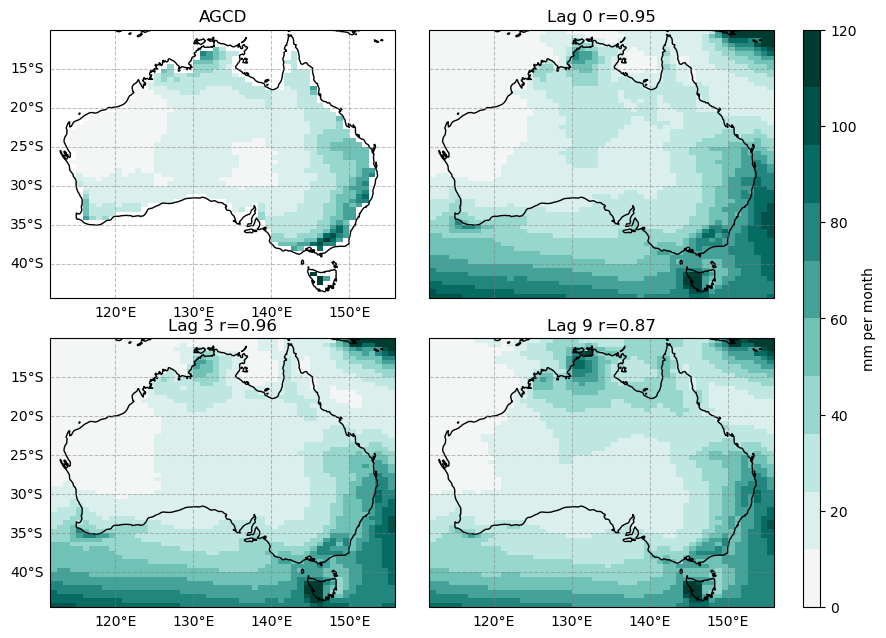

In [84]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])
vmin = 0
vmax = 120

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = agcd_regrid.sel(year=son_lag0_yearly.year).mean(dim='year').plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('AGCD')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = son_lag0_yearly_aus.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 0 r={pc0:.2f}')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = son_lag3_yearly_aus.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 3 r={pc3:.2f}')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = son_lag9_yearly_aus.mean(dim=['year','ensemble']).plot(ax=ax, cmap=cmap_green, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f'Lag 9 r={pc9:.2f}')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('mm per month');

#### Correlation through time

In [87]:
agcd_clim = agcd_regrid.sel(year=son_lag0_yearly.year).mean(dim='year')
son_lag0_clim = son_lag0_yearly_aus.mean(dim=['year','ensemble'])
son_lag3_clim = son_lag3_yearly_aus.mean(dim=['year','ensemble'])
son_lag9_clim = son_lag9_yearly_aus.mean(dim=['year','ensemble'])

In [88]:
agcd_final = agcd_regrid.sel(year=son_lag0_yearly.year) - agcd_clim
lag0_final = son_lag0_yearly_aus.mean(dim='ensemble') - son_lag0_clim
lag3_final = son_lag3_yearly_aus.mean(dim='ensemble') - son_lag3_clim
lag9_final = son_lag9_yearly_aus.mean(dim='ensemble') - son_lag9_clim

In [90]:
corr0 = xr.corr(agcd_final, lag0_final, dim='year')
corr3 = xr.corr(agcd_final, lag3_final, dim='year')
corr9 = xr.corr(agcd_final, lag9_final, dim='year')

In [85]:
corr0 = xr.corr(agcd_regrid.sel(year=son_lag0_yearly.year).chunk({'year':-1}), son_lag0_yearly_aus.mean(dim='ensemble'), dim="year")
corr3 = xr.corr(agcd_regrid.sel(year=son_lag3_yearly.year).chunk({'year':-1}), son_lag3_yearly_aus.mean(dim='ensemble'), dim="year")
corr9 = xr.corr(agcd_regrid.sel(year=son_lag9_yearly.year).chunk({'year':-1}), son_lag9_yearly_aus.mean(dim='ensemble'), dim="year")

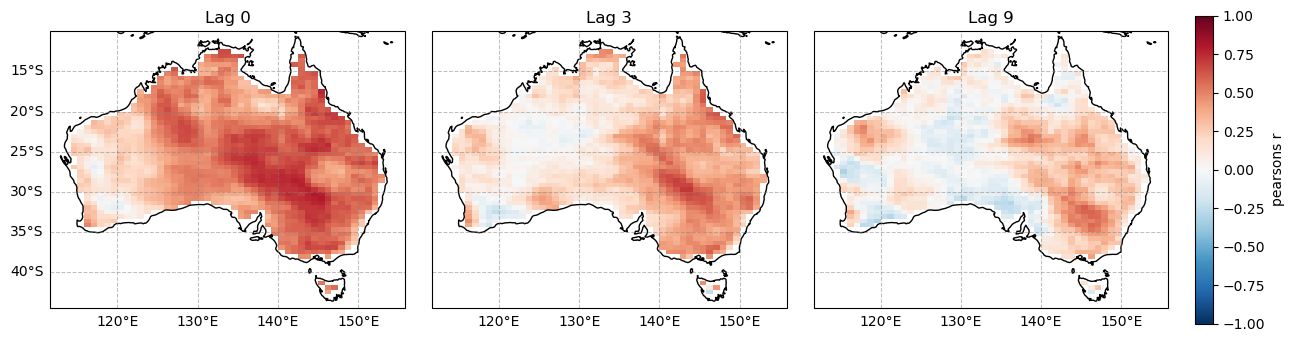

In [91]:
fig = plt.figure(figsize=(15, 4))  
gs = gridspec.GridSpec(1, 4, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 1, 0.05])
vmin = -1
vmax = 1

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = corr0.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = corr3.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 3')
ax = format_gridlines(ax, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im = corr9.plot(ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Lag 9')
ax = format_gridlines(ax, bottom_labels=True)

# First colorbar for precip
cax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('pearsons r');

In [94]:
client.close()

In [36]:
import os
sys.stderr=open(os.devnull,'w')